In [ ]:
!pip install kaggle

In [ ]:
import json
import os
from pathlib import Path

# your api key
api_key = {
    'username': "satrianugrahasaputra",
    'key': "126d19094ea0191233e8313d5bc1eab6"
}

# Uses pathlib Path to define the path to .kaggle directory in user's home
kaggle_path = Path.home() / '.kaggle'
os.makedirs(kaggle_path, exist_ok=True)

# Opens file and dumps python dict to json object
with open(kaggle_path / 'kaggle.json', 'w') as handle:
    json.dump(api_key, handle)

# Modify permissions after creating the file
os.chmod(kaggle_path / 'kaggle.json', 0o600)

In [ ]:
!kaggle datasets download uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
100% 211k/211k [00:00<00:00, 560kB/s]
100% 211k/211k [00:00<00:00, 559kB/s]


In [ ]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Layers
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, Dropout

loading data

In [ ]:
df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.columns = ['label', 'text']
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Visualizing Data

 Dalam assignment kali ini, visualisasi data akan digunakan untuk mengeksplorasi karakteristik dataset untuk mendapatkan tentang pesan teks yang diklasifikasikan sebagai spam atau ham.

Salah satu langkah pertama dalam visualisasi data adalah membuat visualisasi distribusi kelas dalam dataset. Hal ini akan memberikan gambaran tentang seberapa seimbang atau tidak seimbangnya dataset tersebut, dan ini akan membantu untuk mengidentifikasi potensi masalah dengan ketidakseimbangan kelas.

Aspek penting lain dari visualisasi data dalam assignment kali ini adalah mengetahui kata dari kata-kata yang paling umum di dalam pesan spam dan ham. Hal ini akan memungkinkan untuk melihat jenis kata yang paling sering digunakan, dan ini dapat membantu untuk mengidentifikasi kata mana yang paling dapat memprediksi sebuah pesan sebagai spam atau ham.

<ipython-input-11-c4a8a03b86d0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, order = class_distribution.index, palette="Blues")


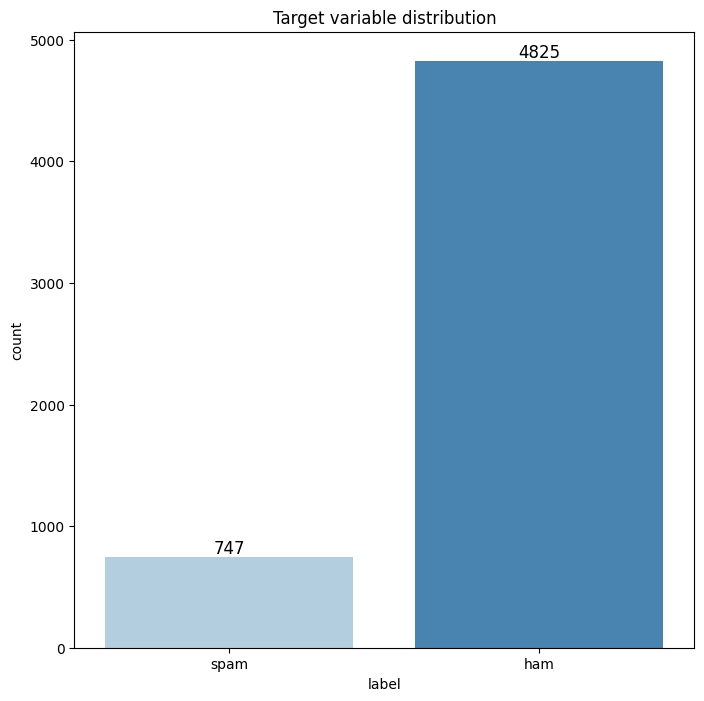

In [ ]:
# Plotting a class distribution barplot
class_distribution = df['label'].value_counts().sort_index(ascending = False)
plt.figure(figsize=(8,8))
ax = sns.countplot(x='label', data=df, order = class_distribution.index, palette="Blues")
for i in ax.containers:
    ax.bar_label(i, label_type = 'edge', fontsize = 12)
plt.title('Target variable distribution')
plt.show()

Dalam dataset ini, ada total 4825 pesan teks yang dilabeli sebagai “ham” dan 747 yang dilabeli sebagai “spam”. Hal ini menunjukkan ketidakseimbangan kelas yang signifikan, dengan sekitar 6 kali lebih banyak pesan ham daripada pesan spam.

Untuk mengatasi masalah ini, maka menggunakan teknik seperti pengambilan sampel berlebih pada kelas minoritas dengan metode SMOTE (Synthetic Minority Over-samplingTechnique)  untuk menyeimbangkan dataset sebelum melatih model.

Langkah visualisasi berikutnya adalah menggunakan word cloud untuk memvisualisasikan kata-kata yang paling umum di dalam pesan spam dan ham. word cloud adalah cara yang populer untuk memvisualisasikan frekuensi kata-kata dalam teks, dengan kata-kata yang paling umum muncul lebih besar dan lebih sering di cloud.

Dengan membuat word cloud untuk pesan spam dan ham, maka dapat mengetahui jenis kata yang paling sering digunakan di setiap kelas dan kata mana yang paling sering muncul untuk memprediksi sebuah pesan sebagai spam atau ham. Hal ini dapat berguna untuk memahami karakteristik data dan untuk mengidentifikasi fitur-fitur potensial untuk dimasukkan ke dalam model pembelajaran mesin. Selain itu, ini juga dapat digunakan untuk menyaring stop word, yang merupakan kata-kata umum yang tidak menambah banyak makna pada teks, dan dapat dihapus sebelum proses pelatihan.


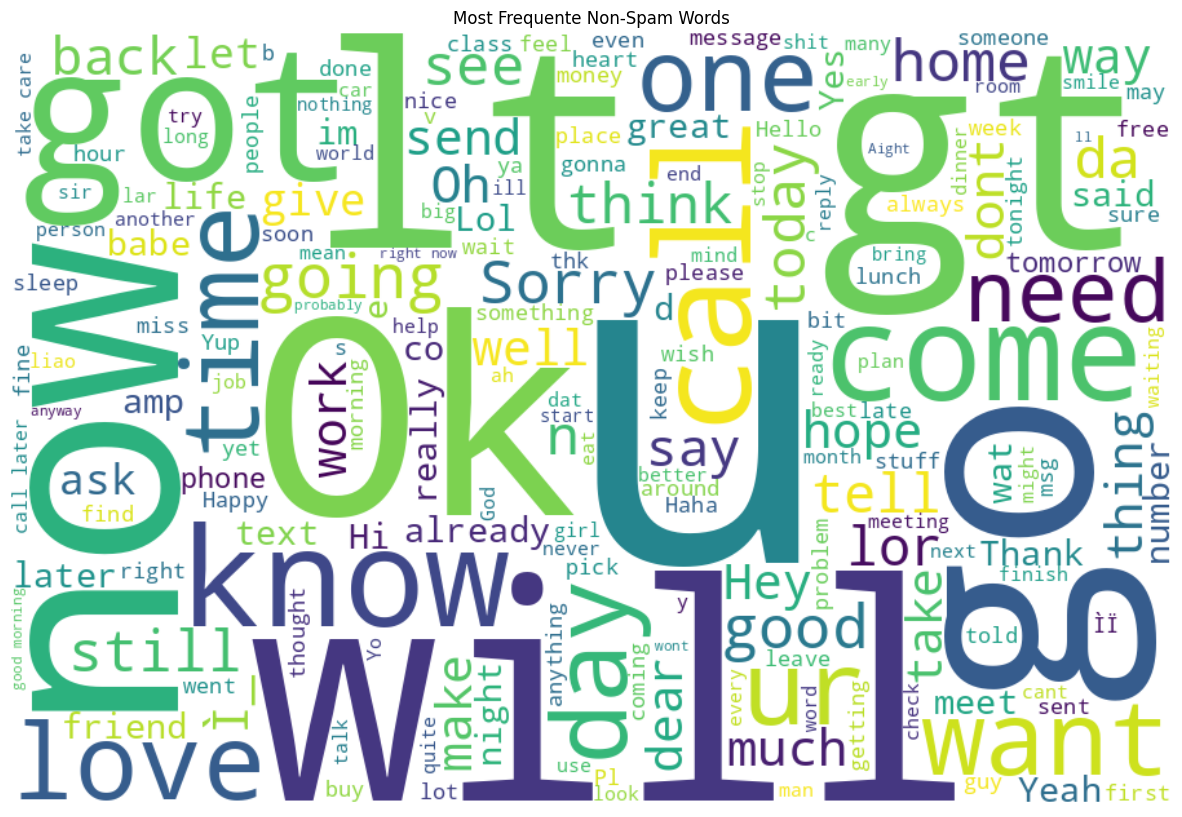

In [ ]:
# Plotting word cloud untuk pesan ham
ham = " ".join(df[df['label'] == 'ham']['text'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(ham)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Non-Spam Words")
plt.show()

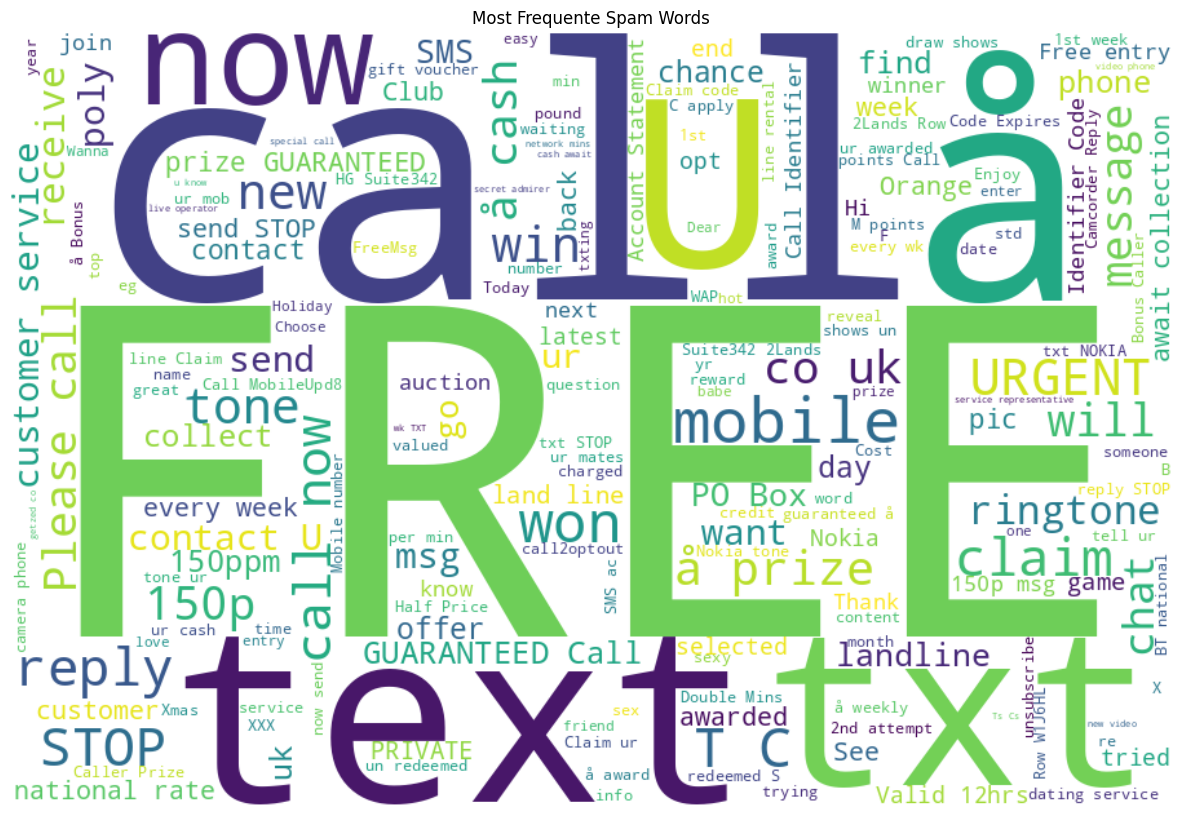

In [ ]:
# Plotting word cloud dari pesan spam
spam = " ".join(df[df['label'] == 'spam']['text'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(spam)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Spam Words")
plt.show()

Dari analisis word clouds dari pesan spam mengungkapkan sejumlah kata yang menyiratkan Kata-kata seperti "URGENT", "FREE", "claim", "Call", "Now", and "GUARANTEED" menunjukkan bahwa pengirim pesan mencoba menciptakan rasa urgensi atau eksklusivitas untuk menarik penerima agar melakukan suatu tindakan, seperti mengeklik sebuah tautan, menelepon sebuah nomor telepon, atau melakukan pembelian. Ini adalah taktik umum yang digunakan oleh pengirim spam untuk mengelabui penerima agar mengungkapkan informasi pribadi atau terjebak dalam penipuan.


Kata-kata ini cenderung menjadi fitur yang berguna untuk model pembelajaran mesin, karena merupakan indikasi pesan spam. Selain itu, keberadaan kata-kata ini dalam sebuah pesan dapat digunakan sebagai ambang batas atau metode berbasis aturan untuk mengklasifikasikan sebuah pesan sebagai spam atau bukan.


Dengan memahami jenis kata dan frasa yang biasanya digunakan dalam pesan spam, maka dapat mengidentifikasi dan menandai pesan-pesan ini sebagai spam dengan lebih baik, yang dapat membantu melindungi penerima agar tidak menjadi korban penipuan atau dicuri informasi pribadinya.


In [ ]:
# contoh pesan ham
print("Ham texts:")
print(df[df['label'] == 'ham']['text'].head())

Ham texts:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: text, dtype: object


In [ ]:
# contoh pesan spam
print("Spams:")
print(df[df['label'] == 'spam']['text'].head())

Spams:
2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: text, dtype: object


Dengan melihat contoh pesan ham dan spam di atas, maka dapat menarik beberapa kesimpulan tentang karakteristik data. Pertama, jelas bahwa pesan spam mengandung kata kunci dan frasa tertentu yang menyiratkan kata-kata, seperti "win", “Free entry”, “WINNER!!”. Kata-kata ini kemungkinan besar merupakan fitur yang berguna untuk model, karena bisa jadi merupakan indikasi pesan spam.

Di sisi lain, pesan bukan spam berisi bahasa yang lebih santai dan tidak mengandung kata kunci yang mendesak atau eksklusif yang biasa terdapat pada spam. Pesan bukan spam juga cenderung lebih bersifat percakapan dan mengandung lebih sedikit huruf besar, tanda baca, dan karakter khusus.

Selain itu, juga dapat diamati bahwa pesan spam cenderung lebih langsung dan menggunakan kata-kata yang kurang umum daripada pesan ham. pada pesan spam juga seperti pada penjualan dan komersial, sementara pesan ham lebih ke arah pribadi dan informal.


###Data Preprocessing

In [ ]:
# Creating a function to clean text data
def text_cleaning(text):
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Converting text to lowercase
    text = text.lower()
    # Removing digits
    text = re.sub(r'\d+','',text)
    # Removing stopwords that are common in the English language
    stop = stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in stop])
    # Lemmatizing text
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    # Removing white spaces
    text = text.strip()

    return text

In [ ]:
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Splitting training and testing sets
X_train, X_test, y_train,y_test = train_test_split(df['text'], df['label'], test_size = 0.4, random_state = 123)

# Applying text_cleaning function
X_train = X_train.apply(text_cleaning)
X_test = X_test.apply(text_cleaning)

In [ ]:
X_train

73                               kkwhere youhow performed
2948                            bruce b down amp fletcher
1000                                  nobut heard abt tat
3993               love cuddle want hold strong arm right
4197    want funk ur fone weekly new tone reply tonesu...
                              ...                        
5218                     accidentally brought em home box
4060    aight ive set free think could text blake addr...
1346    ok stay night xavier sleeping bag im getting t...
3454    need lar jus testing e phone card dunno networ...
3582                         sent maga money yesterday oh
Name: text, Length: 3343, dtype: object

Karena neural network hanya dapat memproses data numerik, tokenisasi dilakukan untuk mengubah teks menjadi representasi numerik, sementara padding diterapkan untuk memastikan bahwa semua sampel input memiliki panjang yang sama

In [ ]:
# Data tokenization and padding
max_lenght = max([len(i) for i in X_train])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_lenght)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_lenght)

Langkah selanjutnya adalah menggunakan SMOTE untuk mengatasi ketidakseimbangan kelas dalam dataset. SMOTE adalah teknik oversampling yang biasa digunakan untuk menyeimbangkan dataset yang tidak seimbang.



In [ ]:
# Fixing class imbalance with SMOTE
smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Counting values after SMOTE
y_train.value_counts()

label
ham     2884
spam    2884
Name: count, dtype: int64

 Setelah di SMOTE, maka memiliki jumlah pesan spam dan ham yang sama.

Langkah selanjutnya adalah menggunakan LabelEncoder untuk mengkodekan variabel target, dengan model neural network hanya dapat memproses data numerik.

In [ ]:
# Encoding target variable
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

###Creating a LSTM Model

In [ ]:
# Defining model structure
model = Sequential()
# Adding embedding layer to convert input data into a dense vector representation
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim = 100, input_length = max_lenght))
# Adding LSTM layers
model.add(LSTM(units=32, return_sequences = True))
model.add(LSTM(units=32))
# Adding a Dense Layer
model.add(Dense(units=32, activation = 'relu'))
# Adding a Dropout layer, in order to prevent overfitting
model.add(Dropout(rate=0.2))
# Adding an output Dense layer
model.add(Dense(units=1, activation = 'sigmoid'))
model

In [ ]:
# Visualizing model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 419, 100)          596500    
                                                                 
 lstm (LSTM)                 (None, 419, 32)           17024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 622933 (2.38 MB)
Trainable params: 622933 

In [ ]:
# Defining an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

In [ ]:
# Compiling model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
# Fitting model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.3, callbacks =[early_stopping])

Epoch 1/10
127/127 [==============================] - 74s 546ms/step - loss: 0.4147 - accuracy: 0.8085 - val_loss: 0.8732 - val_accuracy: 0.5598
Epoch 2/10
127/127 [==============================] - 57s 452ms/step - loss: 0.1849 - accuracy: 0.9349 - val_loss: 0.7660 - val_accuracy: 0.6771
Epoch 3/10
127/127 [==============================] - 59s 469ms/step - loss: 0.0868 - accuracy: 0.9777 - val_loss: 0.6760 - val_accuracy: 0.7637
Epoch 4/10
127/127 [==============================] - 63s 497ms/step - loss: 0.0531 - accuracy: 0.9876 - val_loss: 1.1989 - val_accuracy: 0.6441
Epoch 5/10
127/127 [==============================] - 57s 452ms/step - loss: 0.0357 - accuracy: 0.9936 - val_loss: 1.3169 - val_accuracy: 0.6823
Epoch 6/10
127/127 [==============================] - 57s 448ms/step - loss: 0.0272 - accuracy: 0.9946 - val_loss: 1.5178 - val_accuracy: 0.6540
Epoch 7/10
127/127 [==============================] - 55s 436ms/step - loss: 0.0217 - accuracy: 0.9953 - val_loss: 1.8162 - val_ac

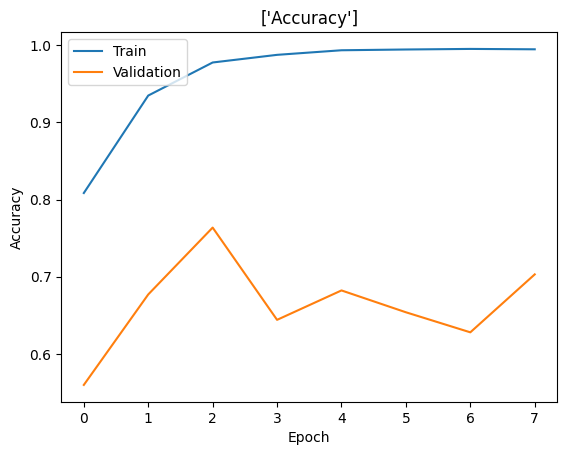

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

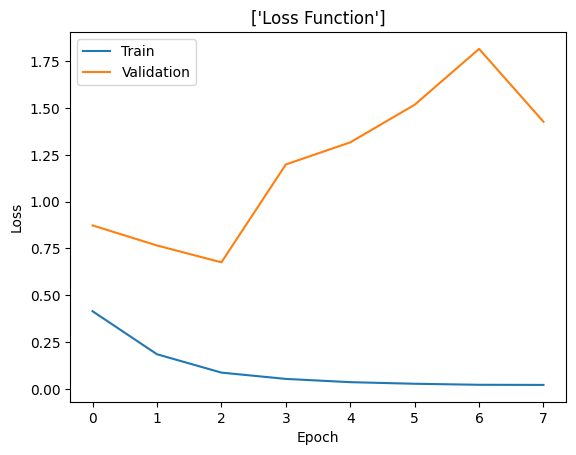

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(['Loss Function'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

Dari hasil Model bisa dilihat tampaknya berkinerja baik pada set pelatihan tetapi tidak begitu baik pada set validasi, yang merupakan indikasi overfitting.

maka disini dapat mencobanya pada set pengujian untuk memeriksa kinerjanya.

In [ ]:
# Running model on testing set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

70/70 [==============================] - 16s 198ms/step


Accuracy: 0.9367429340511441
Precision: 0.6851385390428212
Recall: 0.9444444444444444
F1 Score: 0.7941605839416059


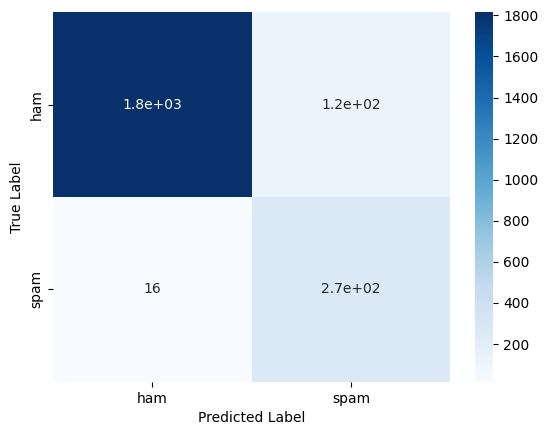

In [ ]:
# Printing metric scores
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Plotting a confusion matrix
cm = confusion_matrix(y_test, y_pred).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Counting total values for ham messages (0) and spam messages (1) on testing set
from numpy import unique
value_counts = dict(zip(*np.unique(y_test, return_counts=True)))
print(value_counts)

{0: 1941, 1: 288}


In [ ]:
# Printing accuracy on testing set
correct = np.count_nonzero(y_pred == y_test)
wrong = np.count_nonzero(y_pred != y_test)

print("The model predicted correctly",correct,"messages")
print("The model predicted incorrectly",wrong,"messages")

The model predicted correctly 3670248 messages
The model predicted incorrectly 1298193 messages


Kesimpulan
Berdasarkan hasil pada set pengujian, tampaknya model ini berkinerja cukup baik dalam hal deteksi spam. Model ini dengan benar mendeteksi 270 pesan spam dari 288 pesan, dan dengan benar menandai 2.146 pesan sebagai spam atau ham, dengan hanya 83 pesan yang ditandai dengan salah.


Namun, pada model ini berkinerja buruk pada data validasi, yang bisa menjadi indikasi overfitting. Ini berarti bahwa model tersebut dapat menyesuaikan diri dengan baik pada data pelatihan tetapi kesulitan untuk menggeneralisasi data baru yang tidak terlihat


Kesimpulannya, assignment kali ini telah mencapai hasil yang baik dalam hal deteksi spam, tetapi kinerja pada set validasi masih dapat ditingkatkan. Untuk meningkatkan performa dari assignment ini, atau proyek serupa lainnya, disarankan untuk menggunakan teknik-teknik untuk mencegah overfitting, menggunakan data yang lebih beragam, menggunakan arsitektur yang lebih canggih, dan menggunakan embedding yang sudah terlatih.